In [60]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import pandas as pd
import numpy as np


def parser(x):
	return datetime.strptime(x, '%Y.%m.%d')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [32]:
series1 = read_csv('EURUSD.csv', index_col=0, header=None, 
                  names = ['date', 'dummy', 'open', 'high', 'low','close','volume'], parse_dates=[0], date_parser=parser)
series=series1['close']
series.head()

date
2007-12-17    1.4400
2007-12-18    1.4413
2007-12-19    1.4383
2007-12-20    1.4330
2007-12-21    1.4357
Name: close, dtype: float64

In [46]:
filename='score_result_eurusd_diff.txt'
f = open(filename , 'w' )
f.write('epoch|neuron|rmse \n' )
f.close()

In [48]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-100], supervised_values[-100:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

#nb_epoch_range=range(100,1100,100)
nb_epoch_range=[100]
#neuron_range=range(1,11)
neuron_range=[1]
for i1 in nb_epoch_range:
    for i2 in neuron_range:
        # repeat experiment
        repeats = 10
        error_scores = []
        for r in range(repeats):
            # fit the model
            lstm_model = fit_lstm(train_scaled, 1, i1, i2)
            # forecast the entire training dataset to build up state for forecasting
            train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
            lstm_model.predict(train_reshaped, batch_size=1)
            # walk-forward validation on the test data
            predictions = list()
            for i in range(len(test_scaled)):
                # make one-step forecast
                X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
                yhat = forecast_lstm(lstm_model, 1, X)
                # invert scaling
                yhat = invert_scale(scaler, X, yhat)
                # invert differencing
                yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
                # store forecast
                predictions.append(yhat)
            # report performance
            rmse = sqrt(mean_squared_error(raw_values[-100:], predictions))
            #print('%d) Test RMSE: %.3f' % (r+1, rmse))
            #error_scores.append([rmse])
 
            f = open( filename, 'a' )
            f.write(str(i1)+'|'+str(i2)+'|'+str(rmse)+'\n' )
            f.close()

print("done")

done


In [49]:
import pandas as pd

#DataFrame.pivot_table(values=None, index=None, columns=None, aggfunc='mean',fill_value=None, margins=False, dropna=True)

df = pd.read_csv(filename,  sep='|')
df.pivot_table(index='epoch',columns='neuron',aggfunc=('count','mean'))

rmse           
       count      mean
neuron     1         1
epoch                 
100       10  0.005236

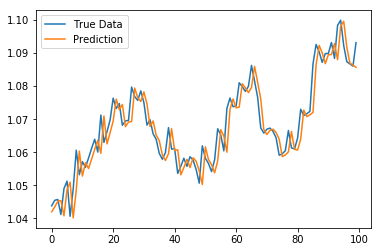

In [50]:
import matplotlib.pyplot as plt

true_data=raw_values[-100:]
predicted_data=predictions

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(true_data, label='True Data')
plt.plot(predicted_data, label='Prediction')
plt.legend()
plt.show()

In [57]:
raw_values[-100:]

array([ 1.04379,  1.04545,  1.0457 ,  1.04114,  1.049  ,  1.05125,
        1.0406 ,  1.04888,  1.06062,  1.05319,  1.05714,  1.05544,
        1.05827,  1.06119,  1.06393,  1.06004,  1.07125,  1.06296,
        1.06624,  1.06973,  1.07637,  1.07324,  1.07477,  1.06816,
        1.06949,  1.06965,  1.07973,  1.07684,  1.07571,  1.07858,
        1.07501,  1.06821,  1.06983,  1.06556,  1.06389,  1.05964,
        1.05788,  1.05988,  1.06744,  1.06093,  1.06112,  1.0536 ,
        1.05571,  1.05819,  1.05572,  1.05865,  1.05764,  1.05475,
        1.05064,  1.06194,  1.05817,  1.05661,  1.05415,  1.0577 ,
        1.0671 ,  1.06526,  1.06041,  1.07325,  1.07641,  1.07379,
        1.07398,  1.08103,  1.07984,  1.07841,  1.07995,  1.08628,
        1.08151,  1.07661,  1.06739,  1.06579,  1.06696,  1.06731,
        1.06632,  1.06435,  1.0591 ,  1.05953,  1.06046,  1.06658,
        1.06131,  1.06101,  1.06432,  1.07302,  1.07111,  1.07166,
        1.07238,  1.08671,  1.09262,  1.0904 ,  1.0872 ,  1.08

In [66]:
predict=np.array(predictions)
predict=predict.reshape(len(predict),1);
raw=raw_values[-100:]
raw=raw.reshape(len(raw),1);

In [80]:
forecast=np.c_[raw,predict]
forecast[:10,:]

array([[ 1.04379   ,  1.04197188],
       [ 1.04545   ,  1.043465  ],
       [ 1.0457    ,  1.04512713],
       [ 1.04114   ,  1.0453667 ],
       [ 1.049     ,  1.04075026],
       [ 1.05125   ,  1.04869129],
       [ 1.0406    ,  1.05093963],
       [ 1.04888   ,  1.04012186],
       [ 1.06062   ,  1.04855629],
       [ 1.05319   ,  1.06033548]])